# ECG Heartbeat Project

## 0. Introduction

This project will use data of Electrocardiogram (ECG) signals of single heartbeats, derived from The PTB Diagnostic ECG Database. The ECG data has two classes: normal heartbeat and abnormal heartbeat. This project aims to utilize neural networks to build a classifier to detect abnormal heartbeat using ECG data.

Data source: https://www.kaggle.com/shayanfazeli/heartbeat

## 1. Loading data and setting environment

First, connect to google drive and load data

In [109]:
# connecting to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [110]:
# copy dataset from google drive to colab
!cp ./drive/My\ Drive/Colab\ Notebooks/ECG\ Heartbeat/ptbdb_normal.csv.zip ./
!cp ./drive/My\ Drive/Colab\ Notebooks/ECG\ Heartbeat/ptbdb_abnormal.csv.zip ./

In [111]:
%%time
# unzip dataset in colab
!mkdir ./ECG_heartbeat_dataset
!unzip -q ptbdb_normal.csv -d ./ECG_heartbeat_dataset
!unzip -q ptbdb_abnormal.csv -d ./ECG_heartbeat_dataset

mkdir: cannot create directory ‘./ECG_heartbeat_dataset’: File exists
replace ./ECG_heartbeat_dataset/ptbdb_normal.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
replace ./ECG_heartbeat_dataset/ptbdb_abnormal.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
CPU times: user 461 ms, sys: 101 ms, total: 562 ms
Wall time: 54.4 s


In [112]:
normal_data_dir = 'ECG_heartbeat_dataset/ptbdb_normal.csv'
abnormal_data_dir = 'ECG_heartbeat_dataset/ptbdb_abnormal.csv'

Load useful libraries

In [113]:
# load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [114]:
normal_df = pd.read_csv(normal_data_dir, header=None)
abnormal_df = pd.read_csv(abnormal_data_dir, header=None)

## 2. Exploration

In [115]:
normal_df.shape

(4046, 188)

In [116]:
abnormal_df.shape

(10506, 188)

The data has two parts: a dataset contains all normal heartbeats and a dataset contains all abnormal heartbeats. They have the sames structure: first 187 columns describing the electrocardiogram (ECG) signal, and the last column a indicator of abnormal status (1 = abnormal; 0 = normal)

4046 observations are normal heartbeats; 10506 observations are abnormal, so we are dealing with a case of imbalanced classification, but not a extreme one.

Next, we proceed to combine the data and split into training and testing set stratified on class.


In [117]:
from sklearn.model_selection import train_test_split

In [118]:
# combine data
df = pd.concat([normal_df, abnormal_df])

# stratified splitting with ratio 8:2
X_train, X_test, y_train, y_test = train_test_split(df.drop(187, axis=1), df[187], test_size=0.2, random_state=1, stratify=df[187])

# turn y into integers
y_train = y_train.astype(int)
y_test = y_test.astype(int)

## 3. Modeling

In [122]:
import warnings
from torch.utils.data.sampler import WeightedRandomSampler
from torch.utils.data.sampler import SubsetRandomSampler
import torch.utils.data
import random

#### 3.1 Define a function to get dataloaders with upsampling to balance training data

In [123]:
def imbalanced_loader(X_train, y_train, X_test, y_test, valid_size=0.05, batch_size=512): # Split train into train + validation 
    """
    Get trainloader, validloader, and testloader for model training. 
    This balances the training batches but keep the validation and 
    testing sets in their original class distribution. 
    
    Outputs: dataloader + testloader, where dataloader =  {"train": trainloader, "val": validloader}
    """
    
    warnings.filterwarnings("ignore") #torch bug
    print ('Getting Data... {}% Validation Set\n'.format(int(np.around(valid_size*100))))
    
    # split training and validation randomly

    #num_train = len(X_train) 
    #indices = list(range(num_train))
    #split = int(np.floor(valid_size * num_train))
    #train_idx, valid_idx = indices[split:], indices[:split]

    num_train = len(X_train) 
    indices = list(range(num_train))
    valid_idx = random.sample( indices, int(np.floor(valid_size*num_train)) )
    train_idx = [x for x in indices if x not in valid_idx]
        
    # print info: batch size, size of train/validation/test data
    print("Batch Size:",batch_size)
    print('\nTrain Len=',len(train_idx),', Validation Len=',len(valid_idx), 'Test Len=',len(y_test))
                                                                                        
    # count and weight of each class in training data
    class_sample_count = np.array([len(np.where(y_train.iloc[train_idx]==t)[0]) for t in np.unique(y_train.iloc[train_idx])])
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in y_train.iloc[train_idx]])
    samples_weight = torch.from_numpy(samples_weight)

    # define train sampler 
    train_sampler = WeightedRandomSampler(torch.tensor(samples_weight,dtype=torch.double), 
                                          len(samples_weight))
    
    # combine training data as tensor 
    trainDataset = torch.utils.data.TensorDataset(torch.from_numpy(X_train.iloc[train_idx,:].to_numpy()),
                                                  torch.from_numpy(y_train.iloc[train_idx].astype(int).to_numpy()))
    
    # defind batch sampler
    train_sampler= torch.utils.data.BatchSampler(sampler=train_sampler, 
                                                 batch_size=batch_size, 
                                                 drop_last=True)
    
    # define training loader
    trainloader = torch.utils.data.DataLoader(dataset = trainDataset, 
                                              batch_size=batch_size, 
                                              num_workers=1, sampler= train_sampler)
  
    # combine validation data as tensor  
    valDataset = torch.utils.data.TensorDataset(torch.from_numpy(X_train.iloc[valid_idx,:].to_numpy()), 
                                                torch.from_numpy(y_train.iloc[valid_idx].astype(int).to_numpy()))
    
    # define validation sampler
    val_sampler = torch.utils.data.RandomSampler(valDataset)
    val_sampler = torch.utils.data.BatchSampler(val_sampler, 
                                                batch_size, 
                                                drop_last=True)
    
    # define validation loader
    validloader = torch.utils.data.DataLoader(dataset = valDataset, 
                                              batch_size=batch_size, 
                                              num_workers=1,
                                              sampler=val_sampler)

    #testset=[]
    #for i,x in enumerate(X_test):
    #    testset.append((torch.from_numpy(x),torch.tensor([y_test[i]])))
    
    # combine test data as tensor
    testDataset = torch.utils.data.TensorDataset(torch.from_numpy(X_test.to_numpy()), 
                                                 torch.from_numpy(y_test.astype(int).to_numpy()))
    
    # define test loader
    testloader = torch.utils.data.DataLoader(dataset = testDataset, 
                                             batch_size=batch_size, 
                                             shuffle=False,
                                             num_workers=1) 

    print("")

    dataloader = {"train": trainloader, "val": validloader}

    print('Train Size Batched=',int(len(dataloader['train'].dataset)/batch_size),
          ', Validation Size Batched=',int(len(dataloader['val'].dataset)/batch_size),
          ', Test Size Batched=',len(testloader))
    
    
    warnings.resetwarnings()

    return dataloader,testloader

In [124]:
# get dataloaders
batch_size=128
dataloader, testloader = imbalanced_loader(X_train=X_train,
                                           y_train=y_train,
                                           X_test=X_test, 
                                           y_test=y_test,
                                           valid_size=0.1,
                                           batch_size=batch_size)

Getting Data... 10% Validation Set

Batch Size: 128

Train Len= 10477 , Validation Len= 1164 Test Len= 2911

Train Size Batched= 81 , Validation Size Batched= 9 , Test Size Batched= 23


#### Check class balance for training

In [125]:
from collections import Counter
for hb,labels in dataloader['train']:
    for hb_index,label in enumerate(labels):
        print(hb_index,hb[hb_index].size(),label.cpu().numpy().shape,Counter(label.cpu().numpy().flatten()))

0 torch.Size([128, 187]) (128,) Counter({1: 67, 0: 61})
1 torch.Size([128, 187]) (128,) Counter({0: 66, 1: 62})
2 torch.Size([128, 187]) (128,) Counter({0: 68, 1: 60})
3 torch.Size([128, 187]) (128,) Counter({0: 69, 1: 59})
4 torch.Size([128, 187]) (128,) Counter({1: 69, 0: 59})
5 torch.Size([128, 187]) (128,) Counter({1: 68, 0: 60})
6 torch.Size([128, 187]) (128,) Counter({0: 65, 1: 63})
7 torch.Size([128, 187]) (128,) Counter({0: 69, 1: 59})
8 torch.Size([128, 187]) (128,) Counter({0: 69, 1: 59})
9 torch.Size([128, 187]) (128,) Counter({1: 77, 0: 51})
10 torch.Size([128, 187]) (128,) Counter({1: 67, 0: 61})
11 torch.Size([128, 187]) (128,) Counter({0: 65, 1: 63})
12 torch.Size([128, 187]) (128,) Counter({0: 72, 1: 56})
13 torch.Size([128, 187]) (128,) Counter({1: 66, 0: 62})
14 torch.Size([128, 187]) (128,) Counter({0: 64, 1: 64})
15 torch.Size([128, 187]) (128,) Counter({0: 71, 1: 57})
16 torch.Size([128, 187]) (128,) Counter({0: 64, 1: 64})
17 torch.Size([128, 187]) (128,) Counter(

#### 3.2 Define Model Architecture

ECG data is a sequence of electronic signols, so we use 1D convoludion as the main building block of the network.

In [126]:
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, num_class):
        super(NeuralNetwork, self).__init__()

        self.conv = nn.Conv1d(in_channels=input_size, out_channels=32, kernel_size=5, stride=1)
        self.conv_pad = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.drop_50 = nn.Dropout(p=0.5)
        self.maxpool = nn.MaxPool1d(kernel_size=5, stride=2)
        self.linear1 = nn.Linear(32*8, 32)
        self.linear2 = nn.Linear(32, 32)
        self.linear3 = nn.Linear(32, num_class)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        residual = self.conv(x)

        # 1
        x = self.conv_pad(residual)
        x = F.relu(x)
        x = self.conv_pad(x)
        x += residual
        x = F.relu(x)
        residual = self.maxpool(x)

        # 2
        x = self.conv_pad(residual)
        x = F.relu(x)
        x = self.conv_pad(x)
        x += residual
        x = F.relu(x)
        residual = self.maxpool(x)
        
        # 3
        x = self.conv_pad(residual)
        x = F.relu(x)
        x = self.conv_pad(x)
        x += residual
        x = F.relu(x)
        residual = self.maxpool(x)

        # 4
        x = self.conv_pad(residual)
        x = F.relu(x)
        x = self.conv_pad(x)
        x += residual
        x = F.relu(x)
        x = self.maxpool(x)        

        # multilayer perceptron
        x = x.view(-1, 32*8)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = self.linear3(x)
        x = self.softmax(x)

        return x


cpu


#### 3.3 Define Functions for Training

In [127]:
import torch.optim as optim
import time 
import sklearn 
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools


def reset_weights(model):
    # reset parameters for conv1d and linear layers
    if isinstance(model, nn.Conv1d) or isinstance(model, nn.Linear):
        model.reset_parameters()


def calc_accuracy(output, y):
    # calculate accuracy training
    max_vals, max_idx = torch.max(output, 1)
    acc = (max_idx == y).sum().data.cpu().numpy() / max_idx.size()[0]
    return acc


def train_model(data_loader, model, criterion, optimizer, n_epochs=50, verbose=True, print_every=10, plot=True, validation=True):
    losses = []
    start = time.time()
    print('Training for {} epochs...\n'.format(n_epochs))

    for epoch in range(n_epochs):
        if verbose == True and epoch % print_every== 0:
            print('\n\nEpoch {}/{}:'.format(epoch+1, n_epochs))

        if validation == True:
            evaluation = ['train', 'val']
        else:
            evaluation = ['train']

        # each epoch has training phase and validation phase
        for phase in evaluation:
            if phase == 'train':
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0

            # iterate over data
            for hb, labels in data_loader[phase]:
                for hb_idx, label in enumerate(labels):
                    HB, label = hb[hb_idx].unsqueeze(1).float(), label

                    # forward
                    outputs = model(HB)
                    acc = calc_accuracy(outputs, label)
                    loss = criterion(outputs, label)

                    # set gradients to zero
                    optimizer.zero_grad()

                    # backward and optimize in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # update running loss
                    running_loss += loss.item()

                losses.append(running_loss)

            # display progress
            if verbose == True and epoch % print_every== 0: 
                print('{} loss: {:.4f} | acc: {:.4f}|'.format(phase, running_loss,acc), end=' ')
        
    if verbose == True:        
        print('\nFinished Training  | Time:{}'.format(time.time()-start))

    # plot results
    if plot == True:
        plt.figure(figsize=(10,10))
        plt.plot(losses[0::2],label='train_loss')
        if validation == True:
            plt.plot(losses[1::2],label='validation_loss')
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.draw()

    return model


#### 3.4 Training

In [128]:
NeuralNetwork(input_size=1, num_class=2).apply(reset_weights)

NeuralNetwork(
  (conv): Conv1d(1, 32, kernel_size=(5,), stride=(1,))
  (conv_pad): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (drop_50): Dropout(p=0.5, inplace=False)
  (maxpool): MaxPool1d(kernel_size=5, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=256, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=32, bias=True)
  (linear3): Linear(in_features=32, out_features=2, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [129]:
hb_classifier = NeuralNetwork(input_size=1, num_class=2)
criterion = nn.NLLLoss()
optimizer = optim.Adam(hb_classifier.parameters(),lr = 0.001) 

Training for 100 epochs...



Epoch 1/100:
train loss: 46.9675 | acc: 0.7109| val loss: 4.1319 | acc: 0.6719| 

Epoch 6/100:
train loss: 16.3001 | acc: 0.9219| val loss: 2.4491 | acc: 0.8750| 

Epoch 11/100:
train loss: 8.2154 | acc: 0.9609| val loss: 0.6920 | acc: 0.9609| 

Epoch 16/100:
train loss: 5.4438 | acc: 0.9766| val loss: 0.4294 | acc: 0.9688| 

Epoch 21/100:
train loss: 3.5942 | acc: 0.9688| val loss: 0.5893 | acc: 0.9922| 

Epoch 26/100:
train loss: 1.5693 | acc: 1.0000| val loss: 0.2073 | acc: 0.9922| 

Epoch 31/100:
train loss: 1.4642 | acc: 0.9844| val loss: 0.2041 | acc: 1.0000| 

Epoch 36/100:
train loss: 1.4437 | acc: 0.9922| val loss: 0.5198 | acc: 0.9922| 

Epoch 41/100:
train loss: 1.4264 | acc: 1.0000| val loss: 0.2651 | acc: 0.9922| 

Epoch 46/100:
train loss: 0.5070 | acc: 1.0000| val loss: 0.3413 | acc: 0.9922| 

Epoch 51/100:
train loss: 0.3141 | acc: 1.0000| val loss: 0.1147 | acc: 1.0000| 

Epoch 56/100:
train loss: 1.3411 | acc: 1.0000| val loss: 0.0876 | a

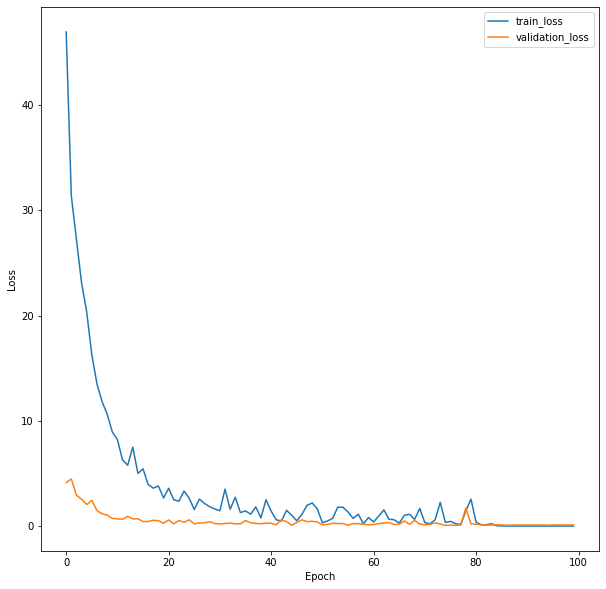

In [130]:
trained_classifier = train_model(data_loader=dataloader, 
                                 model=hb_classifier, 
                                 criterion=criterion,
                                 optimizer=optimizer ,
                                 n_epochs=100,
                                 verbose=True,
                                 print_every=5,
                                 plot=True, 
                                 validation=True)

The training process seems to converge around 50 epochs.

#### 3.5 Evaluation

In [131]:
def evaluate(testloader, trained_model, verbose= True):
    truth=[]
    preds=[]

    # iterate over testing data, get predictions and true labels
    for hb,label in testloader:
        HB, label = hb.float().unsqueeze(1), label
        outputs = trained_model(HB)
        _, predicted = torch.max(outputs, 1)
        preds.append(predicted.numpy().tolist())
        truth.append(label.numpy().tolist())
    
    preds_flat = [item for sublist in preds for item in sublist]
    truth_flat = [item for sublist in truth for item in sublist] 
  
    if verbose == True:
        print('\nEvaluating....')
        print("TEST ACC:",accuracy_score(truth_flat,preds_flat))
        print(classification_report(truth_flat,preds_flat, digits = 3))
    
    return preds_flat,truth_flat

In [132]:
prediction, truth = evaluate(testloader=testloader, trained_model = trained_classifier)


Evaluating....
TEST ACC: 0.9948471315699072
              precision    recall  f1-score   support

           0      0.994     0.988     0.991       809
           1      0.995     0.998     0.996      2102

    accuracy                          0.995      2911
   macro avg      0.995     0.993     0.994      2911
weighted avg      0.995     0.995     0.995      2911



The network get almost perfect classification on test data! It may seems to be an overkill to use a deep learning network to classify, but the learning capability of a deep network has the potential to manage much harder work. This small project demosntrated the capability of 1D CNN on sequence data.